# **신용카드 사기거래 탐지**  

---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* Session 1 - 「Data 전처리 및 EDA」
* Session 2 - 「군집 분석」
* Session 3 - 「이상 탐지 모델링」

In [1]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# 데이터 분석을 위한 기초 라이브러리 호출 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 💳

```
카드사 A는 최근 비트코인 열풍으로 수수료 거래 금액이 늘어 좋으면서도 한 편으로 골치를 썩고 있음.
비트코인 결제를 신용카드로 결제하여 많은 수수료를 얻어가고 있지만, 
그만큼 사기거래가 발생하고 처리해달라는 고객 Claim이 수도 없이 쏟아지기 때문임.
이에 카드사는 사기거래로 예측되는 거래건에 경우 거래를 제한하고 관리하고자 함.

요지) 사기 거래 탐지 모델을 만들어 이를 탐지할 것.
```  

> **데이터 살펴보기**

* 신용카드 거래 관련 데이터
* 데이터 명세 ⬇ 

|Column|Description|
|:---|:---|
|Time|시간|
|V1_V(n)|카드 관련 변수|
|amount|승인금액|
|Class|사기 여부|




In [2]:
# pd.set option
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)  

# Data read
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

df_train.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



## **문제해결 프로세스 정의**
---
> **문제정의**

```
사기 거래 다수 발생
소비자 피해 금액 발생
```  

> **기대효과**

```
이상거래 사전 차단으로 인한 사기 거래 감소 --> 소비자 Claim 감소
소비자 이탈 효과 감소
신규 고객 증가
```

> **해결방안**

```
신용카드 거래 데이터 활용 사기거래 탐지 및 차단
Session 1 : Data 전처리 및 EDA
Session 2 : 차원 축소를 통해 구분이 가능한 데이터인지 확인
Session 3 : 이상 탐지 모델링 수행
```

> **성과측정**  

```
모델 활용 전/후 사기 거래 건수 비교
모델 활용 전/후 소비자 피해 접수 건수 비교
모델 활용 전/후 소비자 피해 금액 비교
```

> **현장적용**  

```
새로운 카드 거래 발생 시 이상 탐지 모델에 Input
Scoring을 통해 Threshold 이상인 거래에 대해서 거래 차단 및 소비자 Contact
```

> **주요 코드 미리 살펴보기**  

```
Session 1 → .value_counts(), sns.boxplot()
Session 2 → df.sample(frac=1), TSNE(), PCA(), TruncatedSVD()
Session 3 → np.percentile, Counter(), IsolationForest(), .decision_function(X)
```

## **Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태), Data type 확인 : 데이터 타입 변환을 통한 전처리

  (2) Null값 확인 (※ 빈 값의 Data): 결측치 처리 수행

  (3) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)

In [3]:
# Data 형태 확인
# 284807 row, 31 col로 구성됨
print('train :', df_train.shape)
print('test :', df_test.shape)

train : (227845, 31)
test : (56962, 31)


In [4]:
# Data type 확인
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227845 non-null  int64  
 1   V1      227845 non-null  float64
 2   V2      227845 non-null  float64
 3   V3      227845 non-null  float64
 4   V4      227845 non-null  float64
 5   V5      227845 non-null  float64
 6   V6      227845 non-null  float64
 7   V7      227845 non-null  float64
 8   V8      227845 non-null  float64
 9   V9      227845 non-null  float64
 10  V10     227845 non-null  float64
 11  V11     227845 non-null  float64
 12  V12     227845 non-null  float64
 13  V13     227845 non-null  float64
 14  V14     227845 non-null  float64
 15  V15     227845 non-null  float64
 16  V16     227845 non-null  float64
 17  V17     227845 non-null  float64
 18  V18     227845 non-null  float64
 19  V19     227845 non-null  float64
 20  V20     227845 non-null  float64
 21  V21     22

In [5]:
# Null 값 확인
print(df_train.isnull().sum().any())    # False : 결측치 없음
print(df_test.isnull().sum().any())     # False : 결측치 없음

False
False


In [6]:
# 학습 데이터 기초 통계량 확인
df_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,79042.795317,-0.067181,-0.013512,0.182509,0.043791,-0.063729,0.030537,-0.026843,0.003985,0.002220,-0.001707,0.076276,-0.044997,0.016712,0.032869,0.049113,-0.005508,0.015157,-0.022871,-0.007285,0.009947,-0.006620,-0.022913,-0.009915,0.001106,0.038058,0.002838,0.000229,0.001962,90.824919,0.001830
std,39505.942766,1.943482,1.657947,1.490424,1.411284,1.373106,1.321418,1.228240,1.209608,1.123421,1.093931,1.033514,1.055865,1.019590,0.965723,0.933914,0.885632,0.874172,0.842785,0.820023,0.779039,0.744486,0.708646,0.630542,0.605982,0.507783,0.486701,0.400459,0.334131,250.503771,0.042742
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-28.009635,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,47694.000000,-0.948923,-0.601200,-0.570507,-0.825409,-0.749452,-0.731710,-0.568947,-0.195151,-0.662052,-0.522691,-0.682523,-0.453236,-0.651170,-0.386002,-0.543186,-0.478638,-0.457551,-0.514930,-0.478224,-0.202755,-0.225626,-0.533306,-0.167111,-0.348755,-0.272309,-0.331174,-0.069586,-0.047871,6.000000,0.000000
50%,73261.000000,-0.034702,0.067702,0.371526,0.040503,-0.122941,-0.237645,0.009786,0.033492,-0.067950,-0.093068,0.030160,0.118530,-0.001618,0.067860,0.120840,0.059928,-0.045769,-0.025814,-0.006005,-0.051033,-0.034878,-0.011846,-0.022942,0.047786,0.075213,-0.060314,0.003528,0.015904,23.400000,0.000000
75%,120396.000000,1.241151,0.781178,1.153264,0.836417,0.531687,0.432322,0.532563,0.332264,0.612865,0.456880,0.835855,0.611638,0.686502,0.509021,0.724565,0.528862,0.410327,0.476318,0.468338,0.145087,0.168377,0.471186,0.126798,0.427389,0.373688,0.253084,0.089114,0.078116,79.990000,0.000000
max,145247.000000,2.454930,22.057729,9.382558,16.875344,34.801666,22.529298,36.877368,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.825654,8.289890,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [7]:
# 시험 데이터 기초 통계량 확인
df_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,157897.285998,0.268720,0.054049,-0.730026,-0.175161,0.254913,-0.122146,0.107370,-0.015942,-0.008882,0.006826,-0.305102,0.179984,-0.066847,-0.131475,-0.196451,0.022032,-0.060626,0.091483,0.029141,-0.039789,0.026478,0.091651,0.039658,-0.004424,-0.152229,-0.011352,-0.000917,-0.007848,78.448549,0.001317
std,7634.315645,1.995936,1.623374,1.394109,1.420639,1.379321,1.368040,1.266224,1.131150,0.993269,1.068267,0.905719,0.701527,0.888275,0.917851,0.807472,0.837334,0.738631,0.813083,0.788994,0.736241,0.692621,0.783585,0.597880,0.604289,0.546185,0.463732,0.416086,0.313250,248.335145,0.036262
min,145248.000000,-40.470142,-50.383269,-48.325589,-5.266509,-113.743307,-20.869626,-23.386192,-39.267378,-4.944054,-12.005487,-4.010268,-9.321153,-3.794187,-14.266836,-4.391307,-6.469187,-9.285186,-4.897766,-4.366767,-54.497720,-21.620120,-7.331078,-36.666000,-2.775670,-8.696627,-1.778061,-9.845808,-15.430084,0.000000,0.000000
25%,151328.250000,-0.793411,-0.588403,-1.585668,-0.934239,-0.423149,-0.892677,-0.482736,-0.257022,-0.553355,-0.605246,-1.009163,-0.250100,-0.638205,-0.614844,-0.709246,-0.423109,-0.574987,-0.421475,-0.367866,-0.240612,-0.240288,-0.575199,-0.131336,-0.375659,-0.449585,-0.289415,-0.073645,-0.061333,4.490000,0.000000
50%,157640.500000,0.094632,0.056880,-0.720610,-0.341982,0.250856,-0.426576,0.154656,-0.026535,0.010382,-0.091820,-0.323375,0.211294,-0.058114,-0.025252,-0.196718,0.089063,-0.161609,0.082762,0.031707,-0.107527,0.007070,0.125659,0.050533,0.016623,-0.215610,-0.012707,-0.007632,-0.027901,18.000000,0.000000
75%,164143.500000,1.983629,0.868882,0.116231,0.415420,0.860548,0.247444,0.731774,0.304086,0.553264,0.439655,0.429309,0.642821,0.568162,0.429702,0.322819,0.501364,0.357684,0.596886,0.421111,0.078758,0.242316,0.732124,0.234253,0.527081,0.194846,0.211671,0.101640,0.079017,64.797500,0.000000
max,172792.000000,2.451888,12.730564,3.937048,15.304184,29.162172,73.301626,120.589494,10.713656,7.871113,12.424602,6.853897,4.293342,7.126883,6.881310,8.877742,17.315112,6.498922,4.079390,5.501747,23.643417,20.063786,7.057496,22.528412,4.584549,6.070850,3.415636,31.612198,15.407019,25691.160000,1.000000


### · Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [8]:
# Target 변수 확인, 0.18%
pd.DataFrame({"count": df_train['Class'].value_counts(), 
              "ratio(%)": df_train['Class'].value_counts(normalize=True)*100})

,count,ratio(%)
0,227428,99.816981
1,417,0.183019


In [9]:
# Target 변수 확인, 0.13%
pd.DataFrame({"count": df_test['Class'].value_counts(), 
              "ratio(%)": df_test['Class'].value_counts(normalize=True)*100})

,count,ratio(%)
0,56887,99.868333
1,75,0.131667


<pre>
정상 데이터와 이상 데이터의 비율이 매우 극단적이긴 하나, 
학습 데이터와 시험 데이터의 비율이 비슷하므로
일단 진행해본 후 추후 조정해보기로 하자.
</pre>

In [10]:
# Time은 Index Col로 보이므로 제외
df_train['Time']
# Time col drop
df_train = df_train.drop(['Time'], axis=1)
df_test = df_test.drop(['Time'], axis=1)

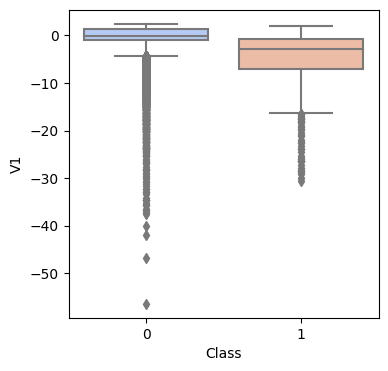

In [11]:
# Box plot 활용 클래스(Class) 별 데이터 비교
plt.figure(figsize=(4, 4))
sns.boxplot(data=df_train, x='Class', y='V1', palette='coolwarm');
# Train Test간의 분포가 어느 정도 차이가 남.
# 각 변수의 분포를 비교해보자.

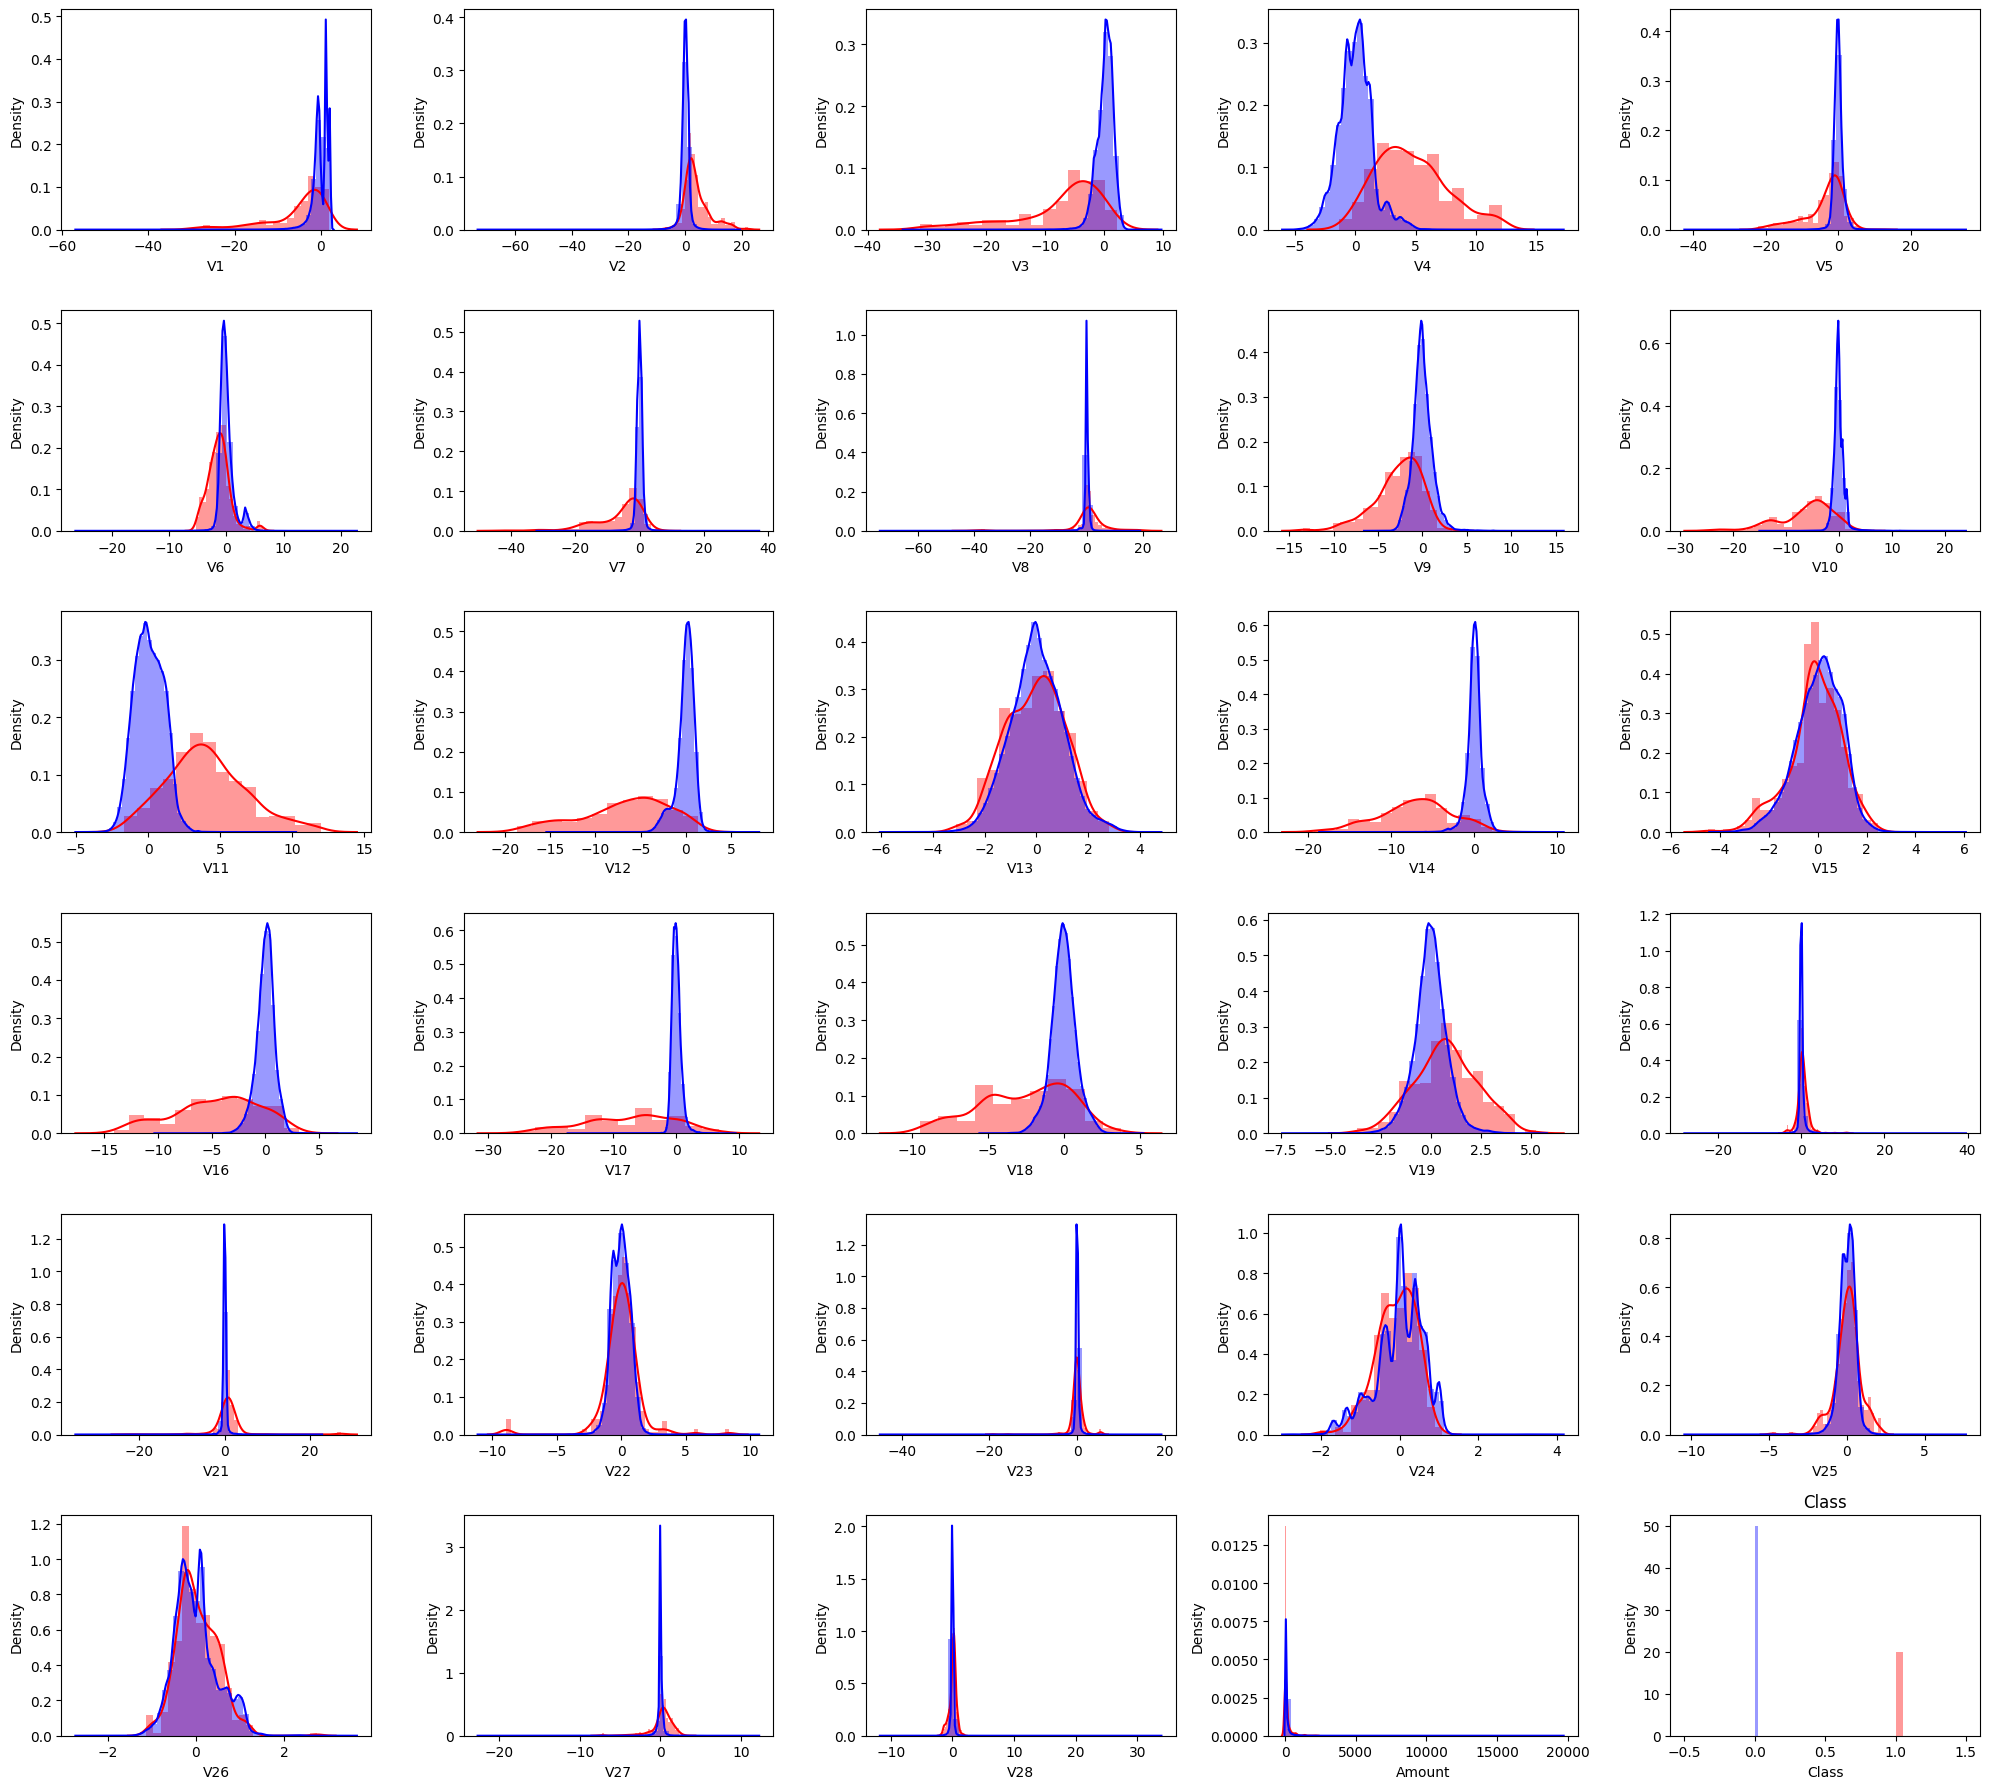

In [12]:
#  for문 활용 시계열 센서 데이터 분포 시각화
# len(df_trian.columns) = 30
col_n = 5
row_n = 6

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20, row_n*3))

for i,col in enumerate(df_train.columns):
    sns.distplot(df_train[df_train['Class']==1][col], ax=ax[int(i/col_n),int(i%col_n)], label='abnormal', color='red')
    sns.distplot(df_train[df_train['Class']==0][col], ax=ax[int(i/col_n),int(i%col_n)], label='normal', color='blue')
    plt.title(col)
    plt.tight_layout()
plt.show();

<pre>
V4, V11 Feature가 Train 데이터 내에서 분포차가 가장 두드러짐.
또한, 이상 데이터일 때 분포가 넓게 퍼지는 현상을 보임.
</pre>

In [13]:
# V4의 분포차 비교
v4_1 = pd.DataFrame(df_train[df_train['Class']==1]['V4'].describe())
v4_0 = pd.DataFrame(df_train[df_train['Class']==0]['V4'].describe())
v4_des = pd.concat([v4_1, v4_0], axis=1)
v4_des.columns = ['abnormal', 'normal']
v4_des

,abnormal,normal
count,417.000000,227428.000000
mean,4.655050,0.035336
std,2.931724,1.393051
min,-1.313275,-5.683171
25%,2.419675,-0.827028
50%,4.273323,0.037722
75%,6.379742,0.830219
max,12.114672,16.875344


In [14]:
# V11의 분포차 비교
v11_1 = pd.DataFrame(df_train[df_train['Class']==1]['V11'].describe())
v11_0 = pd.DataFrame(df_train[df_train['Class']==0]['V11'].describe())
v11_des = pd.concat([v11_1, v11_0], axis=1)
v11_des.columns = ['abnormal', 'normal']
v11_des

,abnormal,normal
count,417.000000,227428.000000
mean,4.046820,0.068996
std,2.743223,1.013600
min,-1.702228,-4.797473
25%,2.191665,-0.683760
50%,3.779750,0.027732
75%,5.705206,0.832037
max,12.018913,10.002190


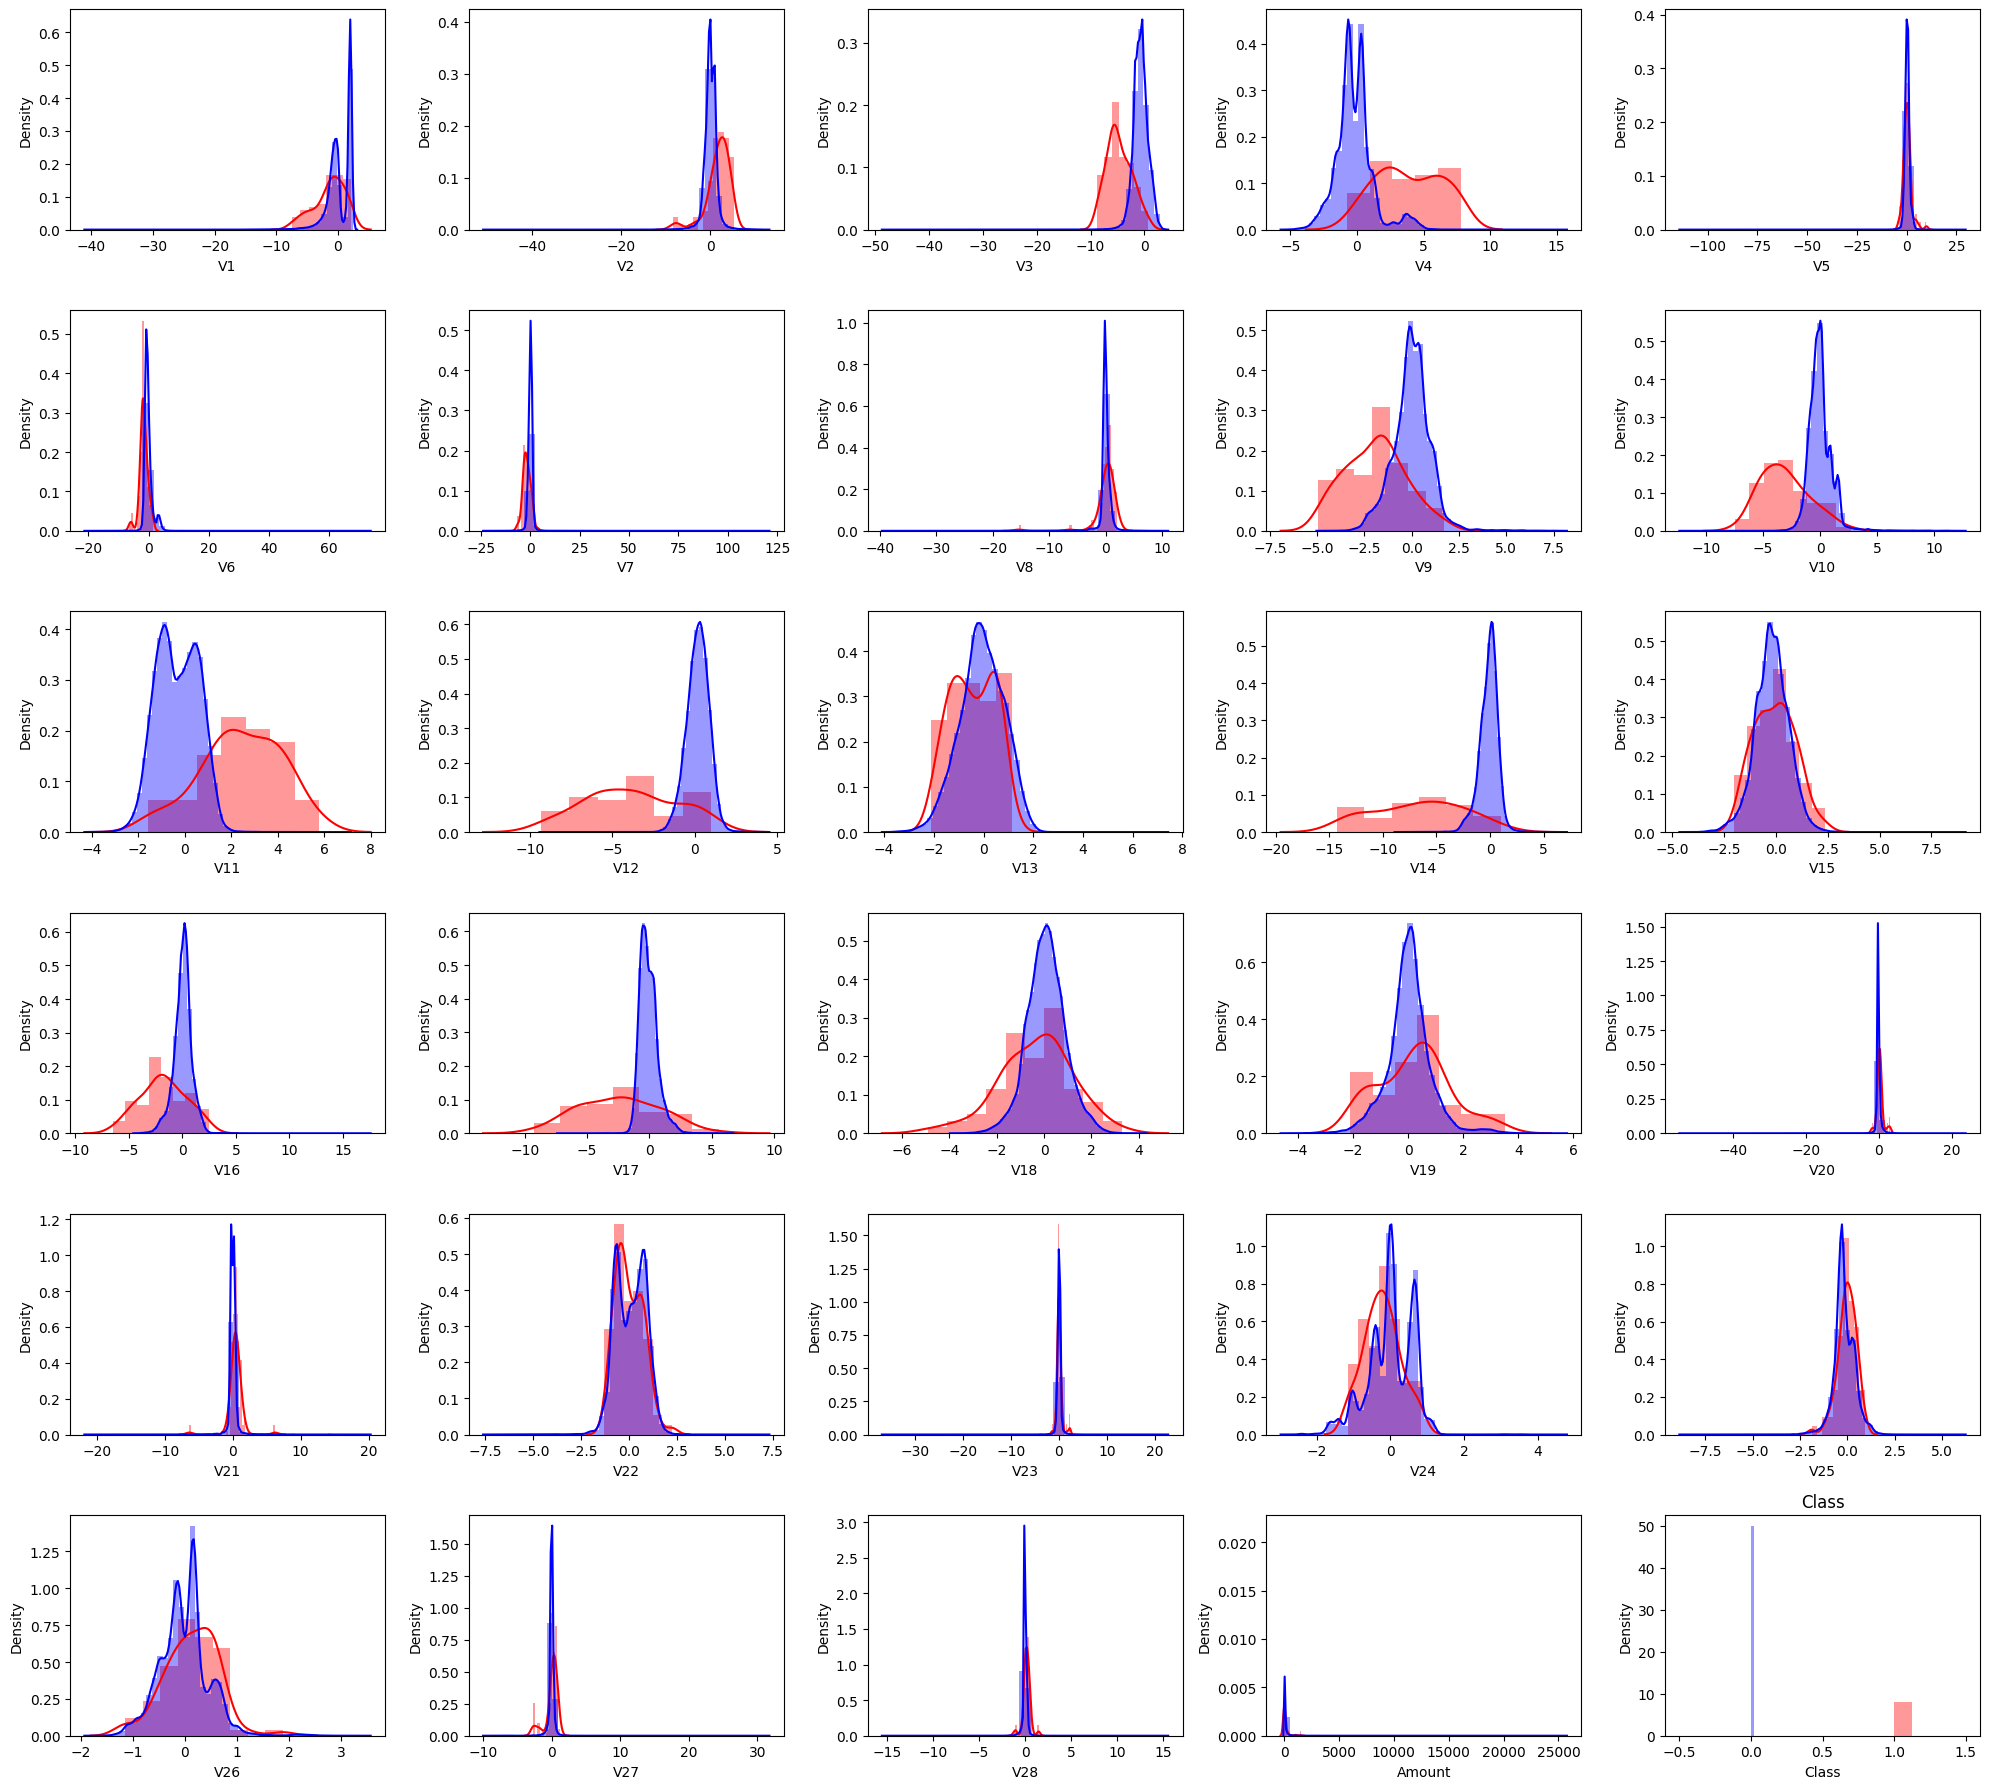

In [15]:
# Test 데이터 내의 분포 차이 시각화
# len(df_trian.columns) = 30
col_n = 5
row_n = 6

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20, row_n*3))

for i,col in enumerate(df_train.columns):
    sns.distplot(df_test[df_test['Class']==1][col], ax=ax[int(i/col_n),int(i%col_n)], label='abnormal', color='red')
    sns.distplot(df_test[df_test['Class']==0][col], ax=ax[int(i/col_n),int(i%col_n)], label='normal', color='blue')
    plt.title(col)
    plt.tight_layout()
plt.show();

## **Session 2: 군집 분석**  **  
---

### · PCA vs T-sne vs TruncatedSVD
---
* 차원축소 및 시각화 작업을 통해 데이터의 정상/비정상 패턴 간 군집 분류가 가능한지 확인

### · Random Down-Sampling
---
* Imbalanced Data이기 때문에 모든 데이터를 비교할 수 없음
* Class 0인 데이터를 Down-sampling을 통해서 Class 1 데이터와 비교
<pre>
Train 데이터 Target(이상) 변수 비율, 0.18%
Test 데이터 Target(이상) 변수 비율, 0.13%
</pre>

In [16]:
# shuffle 기능
train_sample = df_train.sample(frac=1)    # row 전체 shuffle
train_sample.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
170782,1.777846,-0.417036,-2.780241,0.329354,0.772454,-1.230348,1.173705,-0.543412,-0.112657,0.173451,0.421018,0.562909,-0.627091,1.190696,-0.725022,-0.663389,-0.490813,0.210516,0.506664,0.089801,0.417926,0.969117,-0.445508,-0.414871,0.780464,0.114527,-0.118090,-0.069677,184.72,0
60823,0.900626,-0.441543,1.136932,1.034477,-0.265035,2.128974,-1.092706,0.925707,0.854770,-0.182560,1.592668,0.695676,-1.719556,0.277363,0.744045,-0.914654,0.795715,-1.312415,-1.464662,-0.339015,0.097175,0.497863,0.119816,-1.051165,0.012374,-0.293795,0.127522,0.011902,20.57,0
86379,-0.361964,0.928966,1.381522,0.103742,0.089353,-0.902680,0.882634,-0.092200,-0.650169,-0.497730,0.121251,-0.175591,-0.741587,0.488968,0.854187,-0.525767,0.238185,-0.863265,-0.502802,-0.134118,0.078806,0.220908,-0.116036,0.620514,-0.060606,0.324720,0.013291,0.047223,5.74,0
14868,1.010962,0.374927,0.391362,2.700467,0.185366,0.911606,-0.339696,0.482874,-0.309345,0.178070,1.245227,0.120659,-1.623301,-0.798626,-0.831297,0.124432,1.108366,-0.276766,-1.210724,-0.274244,-0.046867,0.029913,-0.036077,-0.393110,0.402675,0.123727,0.042263,0.025902,7.60,0
207905,-0.212464,0.739359,0.539660,0.048613,0.423455,-0.940554,0.829064,-0.231029,-0.221514,-0.232776,-1.068458,-0.487589,-0.815850,0.408090,0.351619,-0.523539,0.057428,-0.442197,1.196380,-0.080175,-0.175414,-0.472524,0.111582,-0.034462,-0.812415,0.288932,0.002015,0.187622,1.98,0


In [17]:
# 샘플 데이터내에서 정상 데이터와 비정상 데이터를 1:1로 나누어서 비교해보자.
fraud_df = train_sample.loc[train_sample['Class'] == 1]
non_fraud_df = train_sample.loc[train_sample['Class'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# 두 데이터를 병합한 후 Shuffle
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
214176,-0.622065,-0.608272,1.074417,-1.876893,-1.655498,0.369641,-1.312199,0.495060,-1.640487,1.008023,-1.352398,-1.021608,0.857456,-0.681595,0.631075,-0.315244,0.674291,0.673936,0.579408,-0.371819,0.051014,0.503800,0.230525,0.592772,-1.000064,-0.174925,-0.084387,0.164410,62.17,0
158730,-0.581597,0.136853,0.470479,-2.685276,0.787522,0.834627,0.529910,0.381538,-1.488412,-0.021296,1.171061,-0.194092,-0.443722,0.167374,-0.460137,0.430906,0.497273,-2.532345,-0.638963,0.088493,0.083600,0.226979,-0.032847,-1.454563,-0.195008,-0.397094,0.348802,0.157964,42.36,0
45203,-2.524012,2.098152,-4.946075,6.456588,3.173921,-3.058806,-0.184710,-0.390420,-3.649812,-4.077585,4.389214,-5.849558,-0.750964,-11.583898,0.838750,-1.461029,0.635694,0.390150,-1.063028,-0.162797,0.027935,0.220366,0.976348,-0.290539,1.161002,0.663954,0.456023,-0.405682,1.00,1
63169,-4.511783,-4.828019,0.995541,-0.512179,-0.660009,0.849987,0.880235,-0.061267,-0.253057,-0.094289,1.259295,0.212042,0.073231,-1.087011,-1.172427,1.036243,0.449031,-1.846234,0.160094,-1.701415,-0.444906,1.045994,2.366849,-0.203054,0.342643,-0.264110,1.002029,-0.335532,592.81,0
47802,-3.365319,2.426503,-3.752227,0.276017,-2.305870,-1.961578,-3.029283,-1.674462,0.183961,-4.980928,3.657882,-6.409822,-1.087310,-8.509433,1.432572,-5.369890,-9.069079,-2.819807,0.874543,-0.036837,2.070008,-0.512626,-0.248502,0.126550,0.104166,-1.055997,-1.200165,-1.012066,88.00,1


In [18]:
# Target 변수 확인: 50% : 50%
pd.DataFrame({"count": new_df['Class'].value_counts(), 
              "ratio(%)": new_df['Class'].value_counts(normalize=True)*100})

,count,ratio(%)
1,417,50.0
0,417,50.0


In [19]:
# Under(Down)-sampling한 데이터 표준화 진행
from sklearn.preprocessing import StandardScaler

X = new_df.drop('Class', axis=1)
y = new_df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [20]:
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=1230).fit_transform(X_scaled.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=1230).fit_transform(X_scaled.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values) # X 사용
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.6 s
PCA took 0.0092 s
Truncated SVD took 0.0099 s


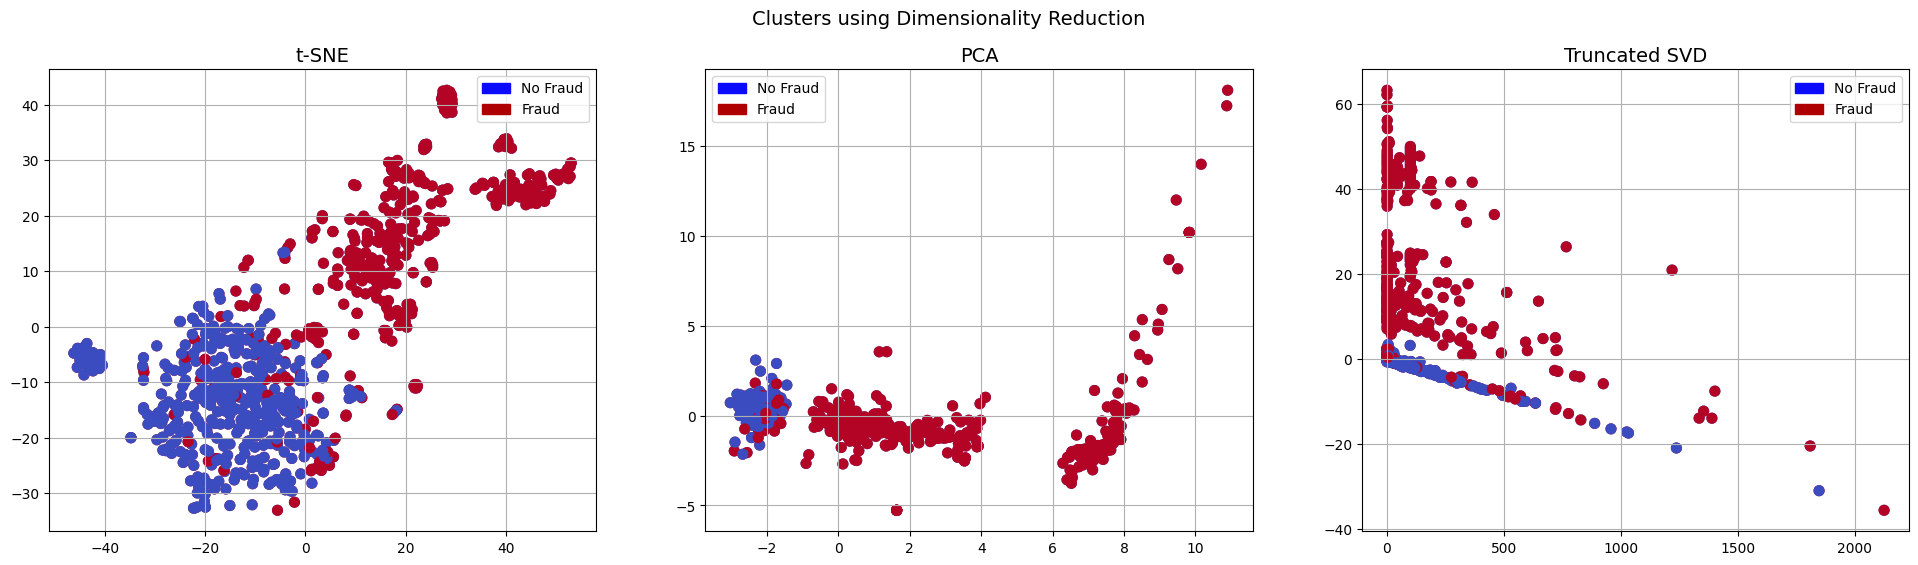

In [21]:
import matplotlib.patches as mpatches

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<pre>
PCA, Truncated SVD 보다t-SNE가 이상과 정상을 보다 잘 구별해냈음.
PCA의 경우 이상 데이터에서 특이 군집이 명확하게 보이나정상 데이터와 섞여 있는 데이터도 많았음.

이상 데이터와 정상 데이터를 구분할 수 있었음.
어떠한 변수 때문에 이상 유무가 발생하는지는 밝혀내지 못함.
</pre>

## **Session 3:이상 탐지 모델링**  
---

### Box plot 이상탐지
___
* 정의
```
# 최소 정상값(min), 1사분위수(Q1, 25분위수), 중앙값, 3사분위수(Q3 75분위 수), 최대 정상값(max)를 나타내는 시각화 방법
# 많은 데이터를 눈으로 확인하기 어려울 때 그림을 이용해 데이터 집합의 범위와 중앙값을 빠르게 확인할 수 있음.
```
<img src = "https://drive.google.com/uc?id=1pQT3D1JhZXEL5Cc79fZJAd5F3LORGezM" width="200">

<pre>
* 장단점
# [장점] 데이터를 눈으로 확인하기 어려울 때, 그림을 이용해 데이터의 범위를 빠르게 파악할 수 있음.
# [장점] 통계적으로 이상치(Outlier)가 있는지 확인 가능
# [장점] 다양한 정보를 손쉽게 표현할 수 있음.

# [단점] 위치정보에 기반하고 있기 때문에 분포를 확인하기는 어려움.
# [단점] 가운데 선은 평균이 아니다. 오해 소지가 있음(Median과 Mean은 다름.)

</pre>

### · IQR Method def.
---

In [22]:
from collections import Counter

def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', len(multiple_outliers))
    
    return multiple_outliers

In [23]:
# Feature list 정의
df_col = list(df_train.columns)
df_col.remove('Class')
print(df_col)

# Sacled data의 col명 재정의
X_scaled.columns = df_col

# detecting outliers, parameter n
feature_list = df_col
Outliers_IQR = IQR_method(X_scaled,5,feature_list)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Total number of outliers is: 119


#### · 모델 평가
---

In [24]:
# Outlier data, dataframe 변환
df_outlier = pd.DataFrame(Outliers_IQR, columns=['index'])
df_outlier['Class_pred'] = 1
df_outlier.set_index('index', inplace = True)
df_outlier.index.name=''
# 원본 데이터에 Concat
df_merge = pd.concat([df_train, df_outlier], axis=1)
df_merge

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Class_pred
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,NaN
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,NaN
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,NaN
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,NaN
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,2.028950,-0.374089,-1.268051,0.349127,-0.057977,-0.515489,-0.087045,-0.146316,1.001341,0.007773,-1.307879,-0.003230,-0.684642,0.109699,-0.461828,-0.330118,-0.087021,-0.437197,0.222290,-0.194318,0.047287,0.323331,0.080683,0.727965,0.070118,0.723291,-0.083032,-0.061277,24.95,0,NaN
227841,0.306600,1.116021,-0.047348,3.593785,2.079047,5.748707,-2.059246,-1.352120,-1.849240,1.000154,-0.330464,-0.202383,-0.129313,0.713813,1.309414,0.399616,0.038217,-0.097967,0.632624,0.865457,-1.458527,-0.234478,0.258831,0.639005,-0.048250,0.144586,0.216385,0.304545,0.76,0,NaN
227842,-1.781954,2.062680,-3.758871,-1.801001,-0.084365,1.919610,-1.454364,-9.825473,-2.073119,-0.005816,-0.644403,0.982035,0.243801,1.541216,-1.949005,-1.278610,-0.179722,1.616439,-0.740407,-0.690810,1.234747,0.376804,-0.339706,-0.216688,-1.555393,0.655873,0.777662,0.272753,359.28,0,NaN
227843,-0.061507,1.024900,-0.170060,-0.263220,0.982164,-1.162749,1.468942,-0.648407,-0.157586,-0.764370,-0.442168,0.024224,0.865039,-1.203879,0.627917,-0.103494,0.238910,0.634188,-0.030689,0.035225,0.299618,1.177722,-0.296209,-0.140335,-0.465171,-0.197933,-0.048916,0.023871,39.40,0,NaN


In [25]:
# Class_pred 빈 곳에 0 삽입
df_merge['Class_pred'] = df_merge['Class_pred'].fillna('0')
df_merge

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Class_pred
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,2.028950,-0.374089,-1.268051,0.349127,-0.057977,-0.515489,-0.087045,-0.146316,1.001341,0.007773,-1.307879,-0.003230,-0.684642,0.109699,-0.461828,-0.330118,-0.087021,-0.437197,0.222290,-0.194318,0.047287,0.323331,0.080683,0.727965,0.070118,0.723291,-0.083032,-0.061277,24.95,0,0
227841,0.306600,1.116021,-0.047348,3.593785,2.079047,5.748707,-2.059246,-1.352120,-1.849240,1.000154,-0.330464,-0.202383,-0.129313,0.713813,1.309414,0.399616,0.038217,-0.097967,0.632624,0.865457,-1.458527,-0.234478,0.258831,0.639005,-0.048250,0.144586,0.216385,0.304545,0.76,0,0
227842,-1.781954,2.062680,-3.758871,-1.801001,-0.084365,1.919610,-1.454364,-9.825473,-2.073119,-0.005816,-0.644403,0.982035,0.243801,1.541216,-1.949005,-1.278610,-0.179722,1.616439,-0.740407,-0.690810,1.234747,0.376804,-0.339706,-0.216688,-1.555393,0.655873,0.777662,0.272753,359.28,0,0
227843,-0.061507,1.024900,-0.170060,-0.263220,0.982164,-1.162749,1.468942,-0.648407,-0.157586,-0.764370,-0.442168,0.024224,0.865039,-1.203879,0.627917,-0.103494,0.238910,0.634188,-0.030689,0.035225,0.299618,1.177722,-0.296209,-0.140335,-0.465171,-0.197933,-0.048916,0.023871,39.40,0,0


In [26]:
# Outlier data 확인
df_merge['Class_pred'].value_counts()
# Target 변수 확인
pd.DataFrame({"count": df_merge['Class_pred'].value_counts(), 
              "ratio(%)": df_merge['Class_pred'].value_counts(normalize=True)*100})

,count,ratio(%)
0,227726,99.947772
1.0,119,0.052228


In [27]:
# Target 변수 확인
pd.DataFrame({"count": df_merge['Class'].value_counts(), 
              "ratio(%)": df_merge['Class'].value_counts(normalize=True)*100})

,count,ratio(%)
0,227428,99.816981
1,417,0.183019


수치는 뭔가 비슷해보임

In [28]:
Y = df_merge["Class"].astype(int)
y_pred = df_merge['Class_pred'].astype(int)

from sklearn.metrics import classification_report
print(classification_report(Y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227428
           1       0.00      0.00      0.00       417

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845



<pre>
성능 평가 결과: 전혀 예측하지 못함
IQR 실패..
</pre>

### · Isolation Forest 이상탐지
---

In [29]:
import copy

from sklearn.ensemble import IsolationForest
# Shuffle 데이터를 이용하여 모델을 개발한 후 df_train, df_test데이터에 적용하여 성능을 평가
train_sample2 = copy.deepcopy(train_sample)

X = train_sample2.drop(['Class'], axis=1)

In [30]:
# Target 변수 확인
pd.DataFrame({"count": train_sample2['Class'].value_counts(), 
              "ratio(%)": train_sample2['Class'].value_counts(normalize=True)*100})

,count,ratio(%)
0,227428,99.816981
1,417,0.183019


In [31]:
# IsolationForest 재학습
model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.018))
model.fit(X)

IsolationForest(contamination=0.018, n_estimators=150)

In [32]:
# IsolationForest Score 및 Prediction
scores=model.decision_function(X)
anomaly=model.predict(X)

train_sample2['scores']=scores
train_sample2['anomaly']=anomaly

In [33]:
# 평가를 위해 다시 라벨링
y = train_sample2['Class']
y_pred = np.where(anomaly==-1, 1, 0)

# 성능평가
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    227428
           1       0.07      0.68      0.13       417

    accuracy                           0.98    227845
   macro avg       0.53      0.83      0.56    227845
weighted avg       1.00      0.98      0.99    227845



In [34]:
# Target 변수 확인
pd.DataFrame({"count": pd.Series(y_pred).value_counts(), 
              "ratio(%)": pd.Series(y_pred).value_counts(normalize=True)*100})

,count,ratio(%)
0,223743,98.199653
1,4102,1.800347


In [35]:
# IsolationForest Score 및 Prediction
X_test = df_test.drop(['Class'], axis=1)
scores=model.decision_function(X_test)
anomaly=model.predict(X_test)

df_test['scores']=scores
df_test['anomaly']=anomaly

In [36]:
# 평가를 위해 다시 라벨링
y_test = df_test['Class']
y_test_pred = np.where(anomaly==-1, 1, 0)

# 성능평가
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56887
           1       0.05      0.55      0.09        75

    accuracy                           0.98     56962
   macro avg       0.52      0.77      0.54     56962
weighted avg       1.00      0.98      0.99     56962



In [37]:
# Target 변수 확인
pd.DataFrame({"count": pd.Series(y_test).value_counts(), 
              "ratio(%)": pd.Series(y_test_pred).value_counts(normalize=True)*100})

,count,ratio(%)
0,56887,98.467399
1,75,1.532601


IQR보다는 좋은 결과이나 이상점을 너무 많이 예측함

### · Scoring 기반 Threshold 조정
---

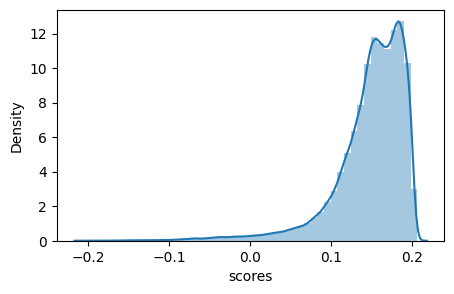

In [38]:
# prediction과 Score 비교
# 음수 값일 수록 Outlier일 확률이 큼
# Score 분포 확인
plt.figure(figsize=(5, 3))
sns.distplot(train_sample2['scores'], label='Train');

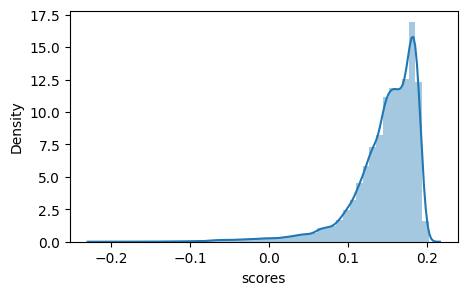

In [44]:
# prediction과 Score 비교
# 음수 값일 수록 Outlier일 확률이 큼
# Score 분포 확인
plt.figure(figsize=(5, 3))
sns.distplot(df_test['scores'], label='Train');

In [39]:
# Score 변수 할당
y_pred = np.where(train_sample2['scores'] < -0.1, 1, 0)
y_test_pred = np.where(df_test['scores'] < -0.1, 1, 0)

In [40]:
# 성능평가
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227428
           1       0.29      0.31      0.30       417

    accuracy                           1.00    227845
   macro avg       0.65      0.65      0.65    227845
weighted avg       1.00      1.00      1.00    227845

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.00      0.00      0.00        75

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



In [43]:
# 적당한 수준
pd.Series(y_pred).value_counts()

0    227409
1       436
dtype: int64

불균형데이터에 대하여 학습/시험 하는 방법에 대하여 더 공부해보아야겠음.